# Learning CStree using Gibbs sampler

In [1]:
import sys
import logging
import random

from causallearn.search.ConstraintBased.PC import pc
import pandas as pd
import matplotlib.pyplot as plt
import cstrees.cstree as ct
import cstrees.scoring as sc
import cstrees.stage as st
import cstrees.learning as ctl
import networkx as nx
import numpy as np
import pp

%load_ext autoreload
%autoreload 2
#logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)


/home/f/l/flrios/NOBACKUP/flrios/miniconda3/envs/cstrees/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Sample a random CStree

In [34]:
np.random.seed(3)
random.seed(3)
p = 5
cards = [2] * p # state space
print("sample cstree")
t = ct.sample_cstree(cards, max_cvars=2, prob_cvar=0.5, prop_nonsingleton=1)
print("sample cstree params")
t.sample_stage_parameters(alpha=2) # optimize parameters 

sample cstree
level 0
level 1
level 2
level 3
sample cstree params


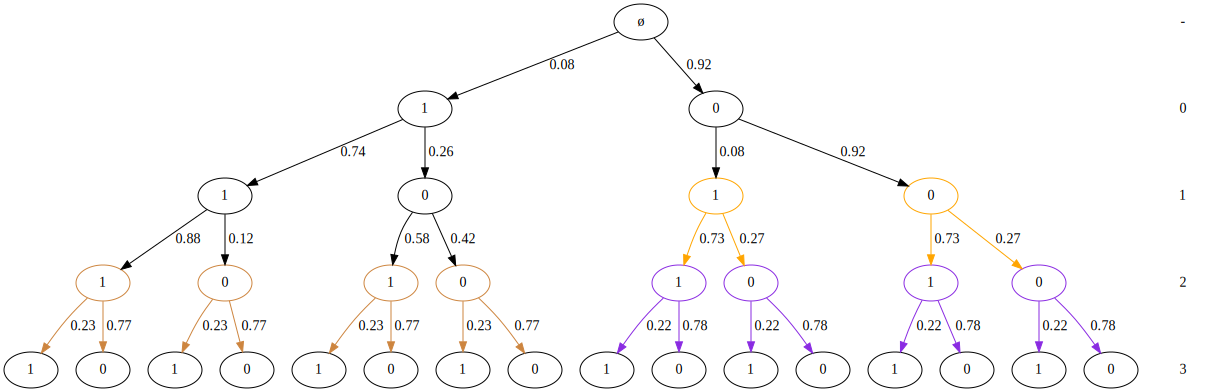

In [48]:
t.plot()

In [49]:
agraphs= t.to_minimal_context_agraphs()
print(len(agraphs))

2


None


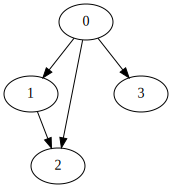

In [50]:
keys = list(agraphs.keys())
print(keys[1])
agraphs[keys[1]]


In [35]:
np.random.seed(6)
x2 = t.sample(2000)
x2

,0,1,2,3,4
0,2,2,2,2,2
1,0,0,0,1,1
2,0,0,1,1,1
3,0,0,1,0,1
4,0,0,1,0,1
...,...,...,...,...,...
1996,0,0,1,0,1
1997,0,1,1,1,1
1998,0,0,0,1,0
1999,0,0,1,0,1


## Create the score tables

In [36]:
t.labels

[0, 1, 2, 3, 4]

In [38]:
poss_cvars = {l:random.sample(list(set(t.labels) - {l}) ,k=3) for l in t.labels}
#poss_cvars = None
poss_cvars

{0: [4, 3, 2], 1: [4, 2, 3], 2: [1, 4, 0], 3: [0, 4, 1], 4: [1, 3, 2]}

In [65]:
score_table, context_scores, context_counts = sc.order_score_tables(x2, 
                                                                    max_cvars=1, 
                                                                    alpha_tot=1.0,
                                                                    method="BDeu",
                                                                    poss_cvars=poss_cvars)

Order score tables: 100%|██████████| 5/5 [00:00<00:00, 69.35it/s]



****** var: 0
subset_str: None

staging :  0
stage_context: None
-520.6396614986245
subset_str: 4

staging :  0
stage_context: 4=0
stage_context: 4=1

staging :  1
stage_context: None
-519.6419082567583
subset_str: 3

staging :  0
stage_context: 3=0
stage_context: 3=1

staging :  1
stage_context: None
-514.9664634416648
subset_str: 2

staging :  0
stage_context: 2=0
stage_context: 2=1

staging :  1
stage_context: None
-499.95934128206466
subset_str: 3,4

staging :  0
stage_context: 4=0
stage_context: 4=1

staging :  1
stage_context: 3=0
stage_context: 3=1

staging :  2
stage_context: None
-515.0770987406992
subset_str: 2,4

staging :  0
stage_context: 4=0
stage_context: 4=1

staging :  1
stage_context: 2=0
stage_context: 2=1

staging :  2
stage_context: None
-500.0771243155423
subset_str: 2,3

staging :  0
stage_context: 3=0
stage_context: 3=1

staging :  1
stage_context: 2=0
stage_context: 2=1

staging :  2
stage_context: None
-500.07712401464215
subset_str: 2,3,4

staging :  0
stag

## The order score tables

In [52]:
pp(score_table)

{
    'max_cvars': 1,
    'poss_cvars': {
        0: [4, 3, 2],
        1: [4, 2, 3],
        2: [1, 4, 0],
        3: [0, 4, 1],
        4: [1, 3, 2],
    },
    'scores': {
        0: {
            '2': -499.95934128206466,
            '2,3': -500.07712401464215,
            '2,3,4': -499.95934097680697,
            '2,4': -500.0771243155423,
            '3': -514.9664634416648,
            '3,4': -515.0770987406992,
            '4': -519.6419082567583,
            'None': -520.6396614986245,
        },
        1: {
            '2': -922.5845212575529,
            '2,3': -922.6836884343985,
            '2,3,4': -922.5220129163704,
            '2,4': -922.657605225276,
            '3': -922.600003415142,
            '3,4': -922.6724055498838,
            '4': -922.5730275789847,
            'None': -922.1492676148993,
        },
        2: {
            '0': -1348.965962590378,
            '0,1': -1349.0837456260117,
            '0,1,4': -1227.9243021636385,
            '0,4': -1228.0

## The context score tables

In [41]:
context_scores

{'cards': {0: 2, 1: 2, 2: 2, 3: 2, 4: 2},
 'scores': {0: {'None': -519.0302235861903,
   '2=0': -313.90825316310355,
   '2=1': -183.9716465779337,
   '3=0': -193.8771672090253,
   '3=1': -319.01200503655866,
   '4=0': -184.840024738024,
   '4=1': -332.98438069361754,
   '2=0,3=0': -128.59185304511283,
   '2=0,3=1': -183.350452299544,
   '2=1,3=0': -57.83268960427145,
   '2=1,3=1': -124.7948352485707,
   '2=0,4=0': -149.11749021022445,
   '2=0,4=1': -168.9020252271902,
   '2=1,4=0': -37.23763272422403,
   '2=1,4=1': -149.01363418912183,
   '3=0,4=0': -92.87805427875597,
   '3=0,4=1': -98.1909103515027,
   '3=1,4=0': -94.69840819877587,
   '3=1,4=1': -227.1466785384479},
  1: {'None': -920.5398297024651,
   '2=0': -409.3836682906234,
   '2=1': -514.4983121967994,
   '3=0': -460.372405950842,
   '3=1': -464.107092833376,
   '4=0': -272.3429120699609,
   '4=1': -651.2475374922356,
   '2=0,3=0': -203.6378369631111,
   '2=0,3=1': -209.31726879498808,
   '2=1,3=0': -261.0839231554754,
   '2=1

## Run the Gibbs sampler

In [42]:
orders2, scores2 = ctl.gibbs_order_sampler(2000, score_table)

initial order: [0, 1, 4, 3, 2]
node: 0 
subset: None
{'None': -520.6396614986245, '4': -519.6419082567583, '3': -514.9664634416648, '2': -499.95934128206466, '3,4': -512.5504146742355, '2,4': -500.93749322454744, '2,3': -497.38469726099436, '2,3,4': -497.68641868870793}
node: 1 
subset: None
{'None': -922.1492676148993, '4': -922.5730275789847, '2': -922.5845212575529, '3': -922.600003415142, '2,4': -895.0651920883446, '3,4': -900.298955526882, '2,3': -923.6619507340396, '2,3,4': -895.1438109655713}
node: 4 
subset: 1
{'None': -1183.907170333807, '1': -1184.3309302978923, '3': -1183.701578916334, '2': -1042.1851896905077, '1,3': -1153.67498048152, '1,2': -1007.3327867759951, '2,3': -1043.1102552246641, '1,2,3': -973.3594003040654}
node: 3 
subset: 0,1,4
{'None': -1391.8091641845365, '0': -1386.135966127577, '4': -1391.6035727670635, '1': -1392.2598999847794, '0,4': -1385.2725892860008, '0,1': -1387.1940681666367, '1,4': -1362.4660187856878, '0,1,4': -1360.4922294412715}
node: 2 
subset

Gibbs order sampler:   0%|          | 0/2000 [00:00<?, ?it/s]

Gibbs order sampler: 100%|██████████| 2000/2000 [00:00<00:00, 2625.75it/s]


### Trajectory score plots

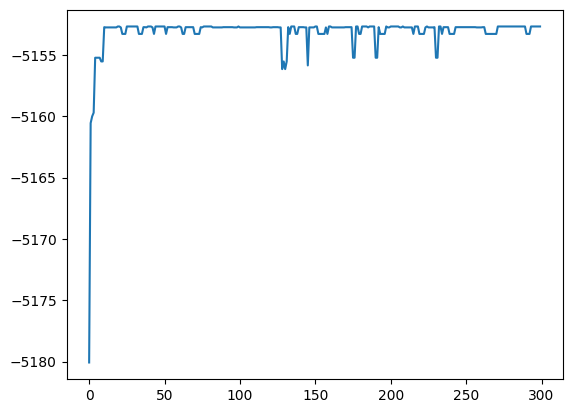

In [43]:
plt.plot(scores2[:300])

### Order position plots

Get the individual variables locations in the order and plot them

In [44]:
var_positions = {var: [x.index(var) for x in orders2] for var in orders2[0]}
var_positions["iteration"] = list(range(len(orders2))) 
plotdf = pd.DataFrame(var_positions)

<AxesSubplot: xlabel='iteration'>

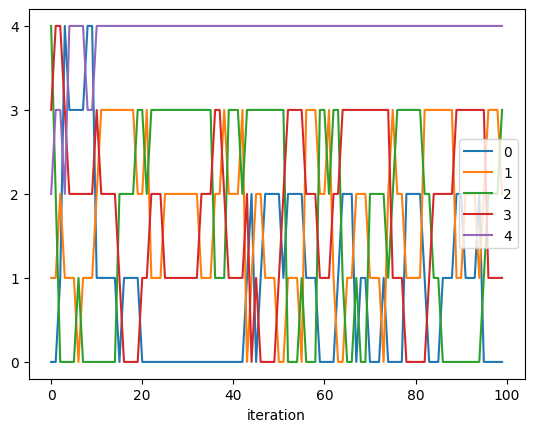

In [45]:
plotdf[:100].plot(x = "iteration", y = range(p), yticks=range(len(orders2[0])))

### Get the maximal scoring order

In [46]:
max(scores2)
maxi = scores2.index(max(scores2))
maporder = orders2[maxi]
maporder

[1, 3, 0, 2, 4]

### Get the maximal scoring CStree for the order

In [49]:
opttree = ctl._optimal_cstree_given_order(maporder, context_scores)


staging level: -1
var 1 (one level above)

staging level: 0
var 3 (one level above)
None
1=0
1=1

staging level: 1
var 0 (one level above)
None
3=0
3=1

staging level: 2
var 2 (one level above)
None
1=0
1=1
0=0,1=0
0=1,1=0
1=1
1=0
0=0,1=1
0=1,1=1
0=0,1=0
0=1,1=0
0=0,1=1
0=1,1=1
0=0
0=1
0=0,1=0
0=0,1=1
0=1
0=0
0=1,1=0
0=1,1=1
0=0,1=0
0=0,1=1
0=1,1=0
0=1,1=1

staging level: 3
var 4 (one level above)
None
1=0
1=1
1=0,3=0
1=0,3=1
1=1
1=0,2=0
1=0,2=1
1=1
1=0
1=1,3=0
1=1,3=1
1=0
1=1,2=0
1=1,2=1
1=0,3=0
1=0,3=1
1=1,3=0
1=1,3=1
1=0,3=0
1=0,3=1
1=1,2=0
1=1,2=1
1=0,2=0
1=0,2=1
1=1,3=0
1=1,3=1
1=0,2=0
1=0,2=1
1=1,2=0
1=1,2=1
3=0
3=1
1=0,3=0
1=1,3=0
3=1
2=0,3=0
2=1,3=0
3=1
3=0
1=0,3=1
1=1,3=1
3=0
2=0,3=1
2=1,3=1
1=0,3=0
1=1,3=0
1=0,3=1
1=1,3=1
1=0,3=0
1=1,3=0
2=0,3=1
2=1,3=1
2=0,3=0
2=1,3=0
1=0,3=1
1=1,3=1
2=0,3=0
2=1,3=0
2=0,3=1
2=1,3=1
2=0
2=1
1=0,2=0
1=1,2=0
2=1
2=0,3=0
2=0,3=1
2=1
2=0
1=0,2=1
1=1,2=1
2=0
2=1,3=0
2=1,3=1
1=0,2=0
1=1,2=0
1=0,2=1
1=1,2=1
1=0,2=0
1=1,2=0
2=1,3=0
2=1,3=1
2=0,3=0
2

## Estimate the CStree parameters

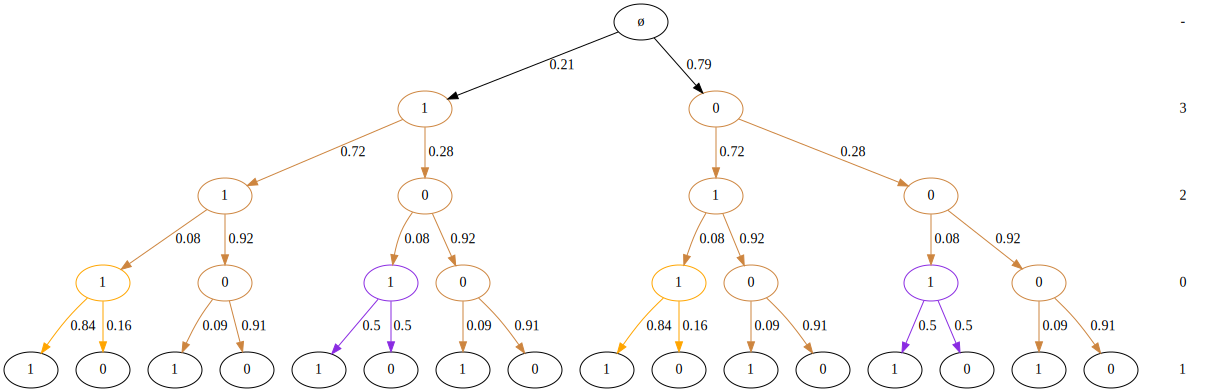

In [17]:
opttree.estimate_stage_parameters(x2, alpha_tot=2.0, method="BDeu")
opttree.plot()

## Plot the DAG representation

In [ ]:
agraphs= opttree.to_minimal_context_agraphs()
len(agraphs)

2

None


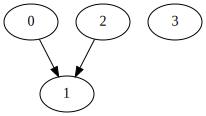

In [ ]:
keys = list(agraphs.keys())
print(keys[0])
agraphs[keys[0]]
